## Prediction Modeling
### Machine Learning Foundations with Python - SP23
### Team Name: Team 8 (Grace Eunji Kim, Sajujya Gangopadhyay, Yi-Hsueh Yang)


This notebook is a continuing work from the DataCleaning_Team8.ipynb. We are trying to answer the question below with this entire notebook. The notebook consists of sections on data preparation, data cleaning, data preprocessing, a bit of visualization, and model building.

As a customer, getting to know the rating or word of mouth from others is always helpful before we click on the first episode of any movie. However, it is considered biased or hard to believe the ratings for movies or series on Netflix since many are Netflix Originals. Thus, a third-party impartial unit can play a crucial part, e.g., IMDb and Rotten Tomatoes, here for our reference. We find performing well on both platforms exciting and vital to be viewed as sound production. We are using an IMDb rating dataset combined with the customer rating dataset we got by merging previous movies and series only on Netflix to make predictions of their rating on IMDb.    

#### Question: What is the IMDb rating for a Netflix movie, given its information and rating on Netflix?

In this prediction analysis, the IMDb rating column is our target variable, y, and the rest are our independent variables, X. RMSE is used to measure our models' metrics.

In [113]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV

## Data Preparation

In [114]:
# set low_memory=False to remove warning messages
df = pd.read_csv('final_netflix_dataset.csv', low_memory=False, index_col=0)
print(df.shape) #(6356792, 15)
df.head()

(6356792, 13)


,Year,Cust_Id,User Rating,Title,IMDb Rating,Runtime (IMDb),Genres (IMDb),Num Votes (IMDb),Country,MPA Rating,Runtime (Netflix),Listed_in,Description
0,2003,2173336,5.0,Something's Gotta Give,6.7,128.0,"Comedy, Drama, Romance",124315.0,United States,PG-13,128 min,"Comedies, Romantic Movies","Still sexy at 60, Harry Sanborn wines and dine..."
1,2003,2473170,5.0,Something's Gotta Give,6.7,128.0,"Comedy, Drama, Romance",124315.0,United States,PG-13,128 min,"Comedies, Romantic Movies","Still sexy at 60, Harry Sanborn wines and dine..."
2,2003,900816,3.0,Something's Gotta Give,6.7,128.0,"Comedy, Drama, Romance",124315.0,United States,PG-13,128 min,"Comedies, Romantic Movies","Still sexy at 60, Harry Sanborn wines and dine..."
3,2003,1990901,4.0,Something's Gotta Give,6.7,128.0,"Comedy, Drama, Romance",124315.0,United States,PG-13,128 min,"Comedies, Romantic Movies","Still sexy at 60, Harry Sanborn wines and dine..."
4,2003,662337,4.0,Something's Gotta Give,6.7,128.0,"Comedy, Drama, Romance",124315.0,United States,PG-13,128 min,"Comedies, Romantic Movies","Still sexy at 60, Harry Sanborn wines and dine..."


In [115]:
# getting rid of the columns that are either duplicated from the joining or useless in our model
df.drop(columns=['Cust_Id', 'Description', 'Runtime (Netflix)'], axis=1, inplace=True)

In [116]:
# There are some huge discrepency between these numerical varaibles, thus, scaling is needed prior fitting our model
df.describe()

,Year,User Rating,IMDb Rating,Runtime (IMDb),Num Votes (IMDb)
count,6.356792e+06,6.356792e+06,6.356792e+06,6.356716e+06,6.356792e+06
mean,1.996300e+03,3.657269e+00,6.958398e+00,1.150385e+02,3.352724e+05
std,9.111680e+00,1.051883e+00,9.231991e-01,1.962458e+01,3.772043e+05
min,1.924000e+03,1.000000e+00,2.300000e+00,3.000000e+01,8.100000e+01
25%,1.995000e+03,3.000000e+00,6.400000e+00,9.800000e+01,9.056500e+04
50%,1.999000e+03,4.000000e+00,6.900000e+00,1.130000e+02,2.199190e+05
75%,2.003000e+03,4.000000e+00,7.700000e+00,1.300000e+02,4.054810e+05
max,2.005000e+03,5.000000e+00,8.700000e+00,2.380000e+02,1.939078e+06


In [118]:
# get a understaning of how many categories do we have in those categorical columns, especially eyeballing genres, rating and country.
df[['Title', 'Genres (IMDb)', 'Country', 'MPA Rating', 'Listed_in']].describe()

,Title,Genres (IMDb),Country,MPA Rating,Listed_in
count,6356792,6356792,6286508,6356792,6356792
unique,226,130,51,10,94
top,Monty Python and the Holy Grail,Comedy,United States,R,Action & Adventure
freq,169302,358658,4114982,2448236,603859


## Data Preprocessing

In [120]:
# deal with the genre column, since it is structured as ['Comedy', 'Drama', 'Family'] in every rows, meaning that each rows can have many unique genres,
# Therefore, the 130 unique values of genres shown above is highly over estimated.

# We are getting rid of the whitespaces and comma here in each rows and make them into a list of genres.
df['Genres (IMDb)'] = df['Genres (IMDb)'].apply(lambda x: x.replace(' ','').split(','))

In [121]:
# performing one-hot encoding with multilabelbinarizer which suits large-scale dataset better, 
# especially when we have multiple labels in one column
mlb = MultiLabelBinarizer()
genres_dummies = pd.DataFrame(mlb.fit_transform(df['Genres (IMDb)']), columns=mlb.classes_, index=df.index)
genres_dummies[:5]

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [122]:
# Since we only got 21 columns from our genres, it is not too big of a deal to include all of them into my dataframe
df_final = pd.concat([df, genres_dummies], axis=1)
df_final = df_final.drop('Genres (IMDb)', axis=1)
df_final.head()

,Year,User Rating,Title,IMDb Rating,Runtime (IMDb),Num Votes (IMDb),Country,MPA Rating,Listed_in,Action,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,2003,5.0,Something's Gotta Give,6.7,128.0,124315.0,United States,PG-13,"Comedies, Romantic Movies",0,...,0,0,0,0,1,0,0,0,0,0
1,2003,5.0,Something's Gotta Give,6.7,128.0,124315.0,United States,PG-13,"Comedies, Romantic Movies",0,...,0,0,0,0,1,0,0,0,0,0
2,2003,3.0,Something's Gotta Give,6.7,128.0,124315.0,United States,PG-13,"Comedies, Romantic Movies",0,...,0,0,0,0,1,0,0,0,0,0
3,2003,4.0,Something's Gotta Give,6.7,128.0,124315.0,United States,PG-13,"Comedies, Romantic Movies",0,...,0,0,0,0,1,0,0,0,0,0
4,2003,4.0,Something's Gotta Give,6.7,128.0,124315.0,United States,PG-13,"Comedies, Romantic Movies",0,...,0,0,0,0,1,0,0,0,0,0


In [10]:
# Listed_in consists of genres labeled by Netflix, however it is labeled in a way that is harder to tackle and might have huge 
# overlaps with the genres column, therefore we are not using it in our anaysis
""" df.Listed_in = df.Listed_in.apply(lambda x: x.replace(' ','').split(','))
mlb = MultiLabelBinarizer()
Listed_in_dummies = pd.DataFrame(mlb.fit_transform(df['Listed_in']), columns=mlb.classes_, index=df.index)
Listed_in_dummies[:5] """

" df.Listed_in = df.Listed_in.apply(lambda x: x.replace(' ','').split(','))\nmlb = MultiLabelBinarizer()\nListed_in_dummies = pd.DataFrame(mlb.fit_transform(df['Listed_in']), columns=mlb.classes_, index=df.index)\nListed_in_dummies[:5] "

In [124]:
# perform one-hot encoding on our Rating column and ordinal encoding on year column
ordinal_encoder = OrdinalEncoder()
one_hot_encoder = OneHotEncoder()

# Define a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('year_encoder', ordinal_encoder, ['Year']),
        ('rating_encoder', one_hot_encoder, ['MPA Rating'])
    ])

# We create a pipeline here to do the ordinal_encoding and one_hot encoding for us in a more robust way to avoid data leakage
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
df_transformed = pipeline.fit_transform(df_final)

# Get the rating columns after doing one-hot encoding to it
rating_columns = pipeline.named_steps['preprocessor'].named_transformers_['rating_encoder'].get_feature_names_out(['MPA Rating'])

# Combine column names
columns = ['Year'] + list(rating_columns)

df_transformed = pd.DataFrame(df_transformed.toarray(), columns=columns)
df_transformed.head()

,Year,MPA Rating_G,MPA Rating_NR,MPA Rating_PG,MPA Rating_PG-13,MPA Rating_R,MPA Rating_TV-14,MPA Rating_TV-G,MPA Rating_TV-MA,MPA Rating_TV-PG,MPA Rating_TV-Y7
0,43.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,43.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,43.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,43.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,43.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
# We drop Rating and Year after performing encoding above
# Drop Listed_in due to potential serious overlap
# Drop title, directors and country since they all have numerous distinct value which won't bring much information to the model and might
# create a huge sparse matrix if do one-hot encoding on them.
df_final = df_final.drop(columns=['MPA Rating', 'Year', 'Title', 'Country', 'Listed_in'], axis=1)
df_final = pd.concat([df_final, df_transformed], axis=1)
df_final.head()

,User Rating,IMDb Rating,Runtime (IMDb),Num Votes (IMDb),Action,Adventure,Animation,Biography,Comedy,Crime,...,MPA Rating_G,MPA Rating_NR,MPA Rating_PG,MPA Rating_PG-13,MPA Rating_R,MPA Rating_TV-14,MPA Rating_TV-G,MPA Rating_TV-MA,MPA Rating_TV-PG,MPA Rating_TV-Y7
0,5.0,6.7,128.0,124315.0,0,0,0,0,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,6.7,128.0,124315.0,0,0,0,0,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,6.7,128.0,124315.0,0,0,0,0,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,6.7,128.0,124315.0,0,0,0,0,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,6.7,128.0,124315.0,0,0,0,0,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
# drop 76 rows that contain NAs is trivial in our 6M rows dataset
print(df_final.isna().sum())
df_final.dropna(inplace=True)

User Rating          0
IMDb Rating          0
Runtime (IMDb)      76
Num Votes (IMDb)     0
Action               0
Adventure            0
Animation            0
Biography            0
Comedy               0
Crime                0
Documentary          0
Drama                0
Family               0
Fantasy              0
History              0
Horror               0
Music                0
Musical              0
Mystery              0
Romance              0
Sci-Fi               0
Sport                0
Thriller             0
War                  0
Western              0
Year                 0
MPA Rating_G         0
MPA Rating_NR        0
MPA Rating_PG        0
MPA Rating_PG-13     0
MPA Rating_R         0
MPA Rating_TV-14     0
MPA Rating_TV-G      0
MPA Rating_TV-MA     0
MPA Rating_TV-PG     0
MPA Rating_TV-Y7     0
dtype: int64


In [128]:
#checking if all columns are numerical and are ready to put into ML models
non_numeric_columns = df_final.select_dtypes(exclude=['number'])

if non_numeric_columns.empty:
    print("All columns are numerical.")
else:
    print("Non-numeric columns:\n", non_numeric_columns.columns)

All columns are numerical.


## Visualization

<AxesSubplot: xlabel='IMDb Rating', ylabel='Density'>

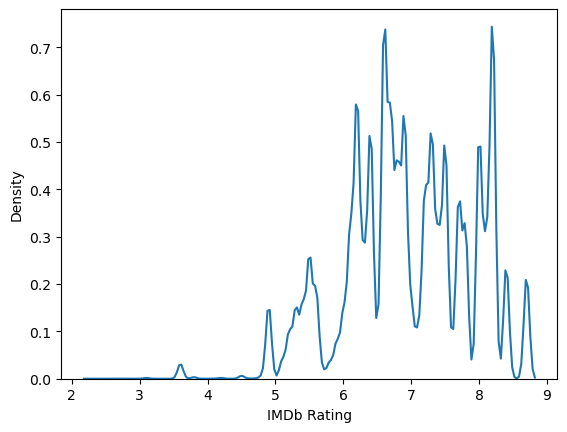

In [129]:
# plot out a density plot of our target variable to see the distribution of it
sns.kdeplot(df_final['IMDb Rating'])

<AxesSubplot: >

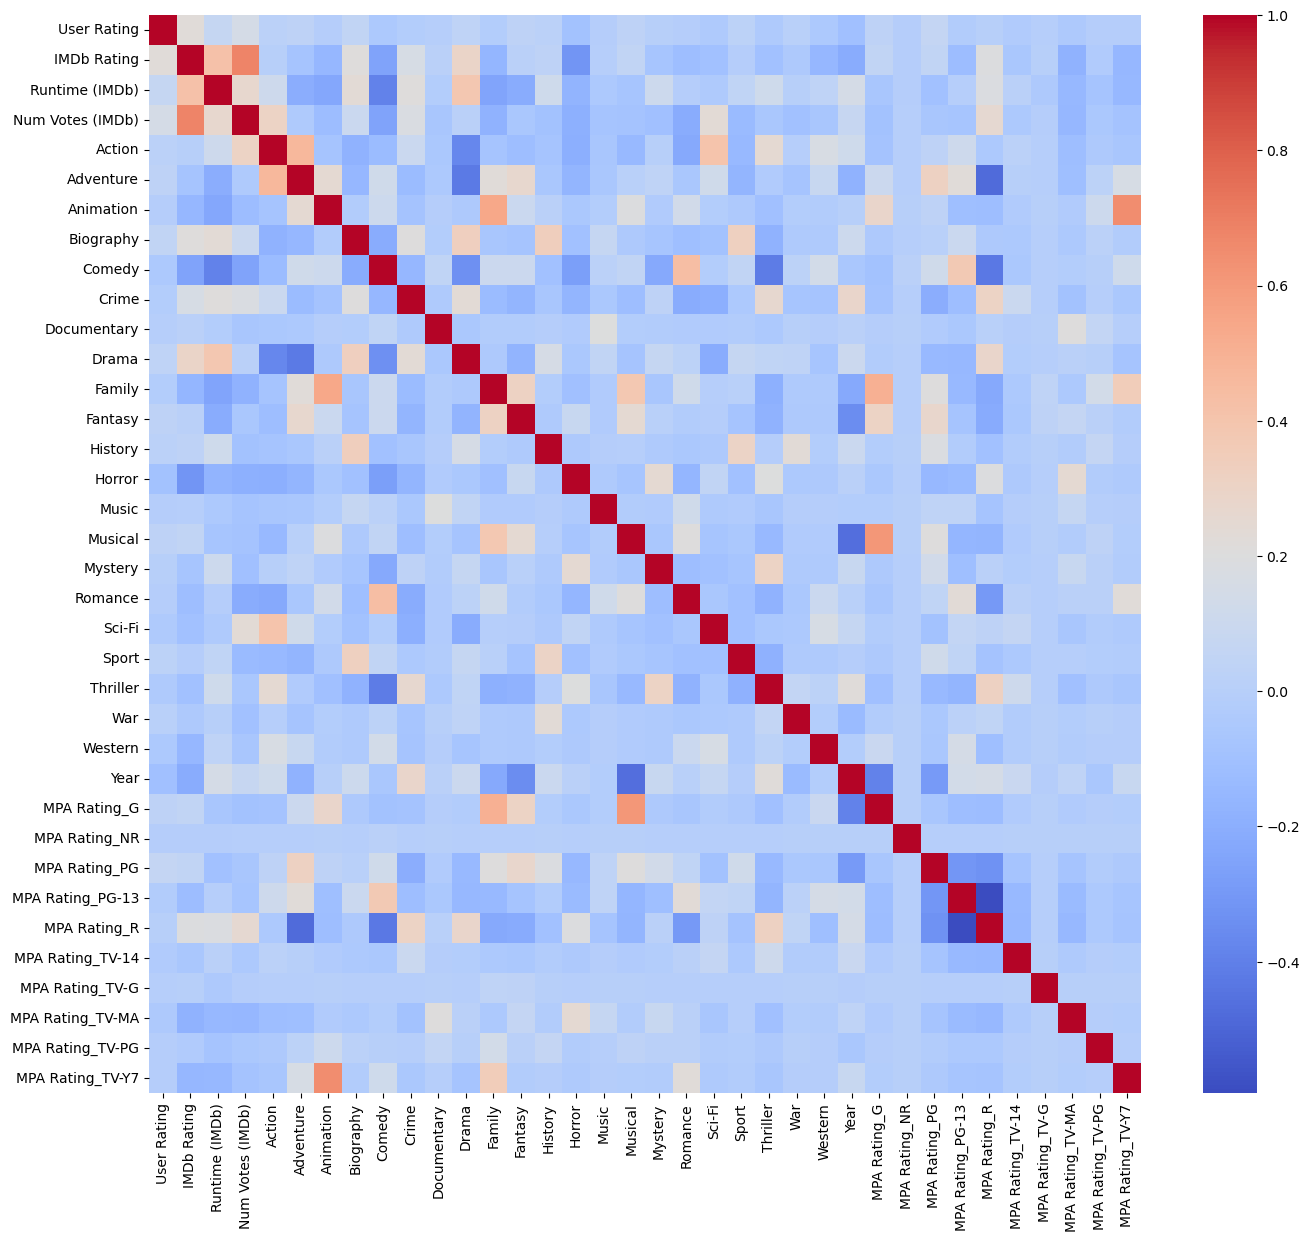

In [130]:
# plot out a heatmap to make sure no two columns are having collinearity
plt.figure(figsize=(16, 14))

corr_matrix = df_final.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')

## Data Split

In [138]:
# create a copy of the original dataset in case something goes wrong
data = df_final.copy()
seed = 7

In [139]:
X = data.drop('IMDb Rating', axis=1)
y = data['IMDb Rating']

In [140]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.2)
print(data.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6356716, 36)
(5085372, 35)
(1271344, 35)
(5085372,)
(1271344,)


## Scaling

In [141]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [142]:
mean_of_y_train = np.mean(y_train)
arr = np.full(len(y_train), mean_of_y_train) 
print(arr)

[6.95826026 6.95826026 6.95826026 ... 6.95826026 6.95826026 6.95826026]


## Baseline

In [143]:
np.sqrt(mean_squared_error(y_train, arr))

0.923110245569982

## Modeling

### Random Forest Regressor

In [144]:
#fitting the first model
rfr = RandomForestRegressor(random_state=seed)

rfr.fit(X_train_scaled, y_train)
y_pred_rfr = rfr.predict(X_test_scaled)

print('RMSE for Random Forest Regressor:', np.sqrt(mean_squared_error(y_test, y_pred_rfr)))

RMSE for Random Forest Regressor: 3.770001907938021e-12


### Gradient Boosting Regressor

In [145]:
#fitting the second model
gbr = GradientBoostingRegressor(random_state=seed)

gbr.fit(X_train_scaled, y_train)
y_pred_gbr = gbr.predict(X_test_scaled)

print('RMSE for Gradient Boosting Regressor:', np.sqrt(mean_squared_error(y_test, y_pred_gbr)))

RMSE for Gradient Boosting Regressor: 0.18308597683447597


### Decision Tree

Although decision tree regressor is getting us a lowest rmse but the result is clearly too good to be true, we are testing whether it might be overfitting.

In [146]:
#fitting the third model
dtr = DecisionTreeRegressor(random_state=seed)

dtr.fit(X_train_scaled, y_train)
y_pred_dtr = dtr.predict(X_test_scaled)

print('RMSE for Decision Tree Regressor:', np.sqrt(mean_squared_error(y_test, y_pred_dtr)))

RMSE for Decision Tree Regressor: 1.0041536114944077e-11


This graph shows that the decision tree model is not overfitting as we might thought, in reality, it is still under fitting. However, the random forest model is performing better than it, so we dive into parameter tuning for random forest regressor only.


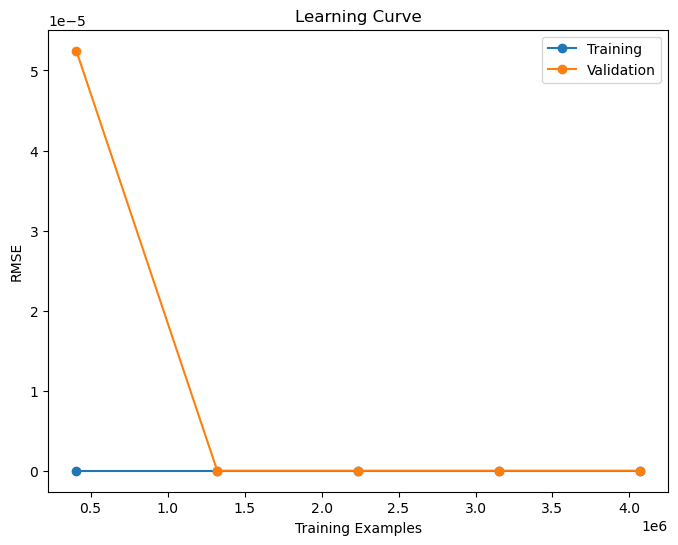

In [147]:
train_sizes, train_scores, test_scores = learning_curve(dtr, X_train_scaled, y_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# make the MSE positive so we can get the RMSE
train_scores = np.sqrt(-train_scores)
val_scores = np.sqrt(-test_scores)

# plotting out the performance of training set and validation set
plt.figure(figsize=(8, 6))
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("RMSE")
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation')
plt.legend(loc='best')
plt.show()

### Gradient Boosting (XGBoost)

In [148]:
#fitting the fourth model
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

model = xgb(random_state=seed)

model.fit(X_train_scaled, y_train)
y_pred_xgb = model.predict(X_test_scaled)

print('RMSE for XGboost Regressor:', np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

RMSE for XGboost Regressor: 0.0011535617602837177


In [157]:
# Comparing which models give the lowest RMSE. 
print('RMSE for Decision Tree Regressor:', np.sqrt(mean_squared_error(y_test, y_pred_dtr)))
print('RMSE for Random Forest Regressor:', np.sqrt(mean_squared_error(y_test, y_pred_rfr)))
print('RMSE for Gradient Boosting Regressor:', np.sqrt(mean_squared_error(y_test, y_pred_gbr)))
print('RMSE for XGboost Regressor:', np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

RMSE for Decision Tree Regressor: 1.0041536114944077e-11
RMSE for Random Forest Regressor: 3.770001907938021e-12
RMSE for Gradient Boosting Regressor: 0.18308597683447597
RMSE for XGboost Regressor: 0.0011535617602837177


## Hyperparameter Tuning

In [154]:
# Setting the parameters in a grid for hyperparameter tuning
param_grid = {
    'n_estimators' : [100, 300],
    'min_samples_leaf' : [2, 5],
    'max_leaf_nodes' : [10, 100]
}

rfr_tuned = RandomForestRegressor(oob_score=True, random_state=seed, n_jobs=-1)
grid_search = GridSearchCV(rfr_tuned, param_grid=param_grid, cv=5, verbose=2)
grid_search.fit(X_train_scaled, y_train)

results = grid_search.cv_results_

print('Best hyperparameters:', grid_search.best_params_) 
#Best hyperparameters: {'max_leaf_nodes': 100, 'min_samples_leaf': 2, 'n_estimators': 300}

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_leaf_nodes=10, min_samples_leaf=2, n_estimators=100; total time= 1.9min
[CV] END max_leaf_nodes=10, min_samples_leaf=2, n_estimators=100; total time= 1.8min
[CV] END max_leaf_nodes=10, min_samples_leaf=2, n_estimators=100; total time= 1.8min
[CV] END max_leaf_nodes=10, min_samples_leaf=2, n_estimators=100; total time= 1.8min
[CV] END max_leaf_nodes=10, min_samples_leaf=2, n_estimators=100; total time= 1.8min
[CV] END max_leaf_nodes=10, min_samples_leaf=2, n_estimators=300; total time= 5.3min
[CV] END max_leaf_nodes=10, min_samples_leaf=2, n_estimators=300; total time= 5.3min
[CV] END max_leaf_nodes=10, min_samples_leaf=2, n_estimators=300; total time= 5.3min
[CV] END max_leaf_nodes=10, min_samples_leaf=2, n_estimators=300; total time= 5.3min
[CV] END max_leaf_nodes=10, min_samples_leaf=2, n_estimators=300; total time= 5.1min
[CV] END max_leaf_nodes=10, min_samples_leaf=5, n_estimators=100; total time= 1.7min
[CV] 

/Users/alexyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Test accuracy: -3.2135737862356857


In [155]:
#fitting the first model
rfr_tuned = RandomForestRegressor(max_leaf_nodes=100, min_samples_leaf=2, n_estimators=300, random_state=seed, oob_score=True, n_jobs=-1)

rfr_tuned.fit(X_train_scaled, y_train)
y_pred_rfr_tuned = rfr_tuned.predict(X_test_scaled)

print('RMSE for Random Forest Regressor:', np.sqrt(mean_squared_error(y_test, y_pred_rfr_tuned)))
print('Model Score:', grid_search.score(X_test_scaled, y_test))

RMSE for Random Forest Regressor: 0.06963592210370145
Test accuracy: 0.9943151071402174


Here we got our best model, with a robust RMSE of 0.069 and a model score (R-squared) of 0.99 

Could also done with pipeline, putting all models in a parameter grid and let utilize gridsearch CV to get us the best answer.

## Pipeline

In [150]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Define the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor())
])

In [151]:
# create a grid of parameters for each models to be plugged into gridsearchCV
param_grid = [
    {
        'model': [DecisionTreeRegressor(random_state=seed)],
    },
    {
        'model': [RandomForestRegressor(random_state=seed, oob_score=True, n_jobs=-1)],
    },
    {
        'model': [GradientBoostingRegressor(random_state=seed)],
    },
    {
        'model': [xgb(random_state=seed)],
        'model__n_estimators': [50, 100],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.1, 0.01]
    }
]

# Perform the grid search over the hyperparameters for each model
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring=make_scorer(rmse, greater_is_better=False), return_train_score=True)
grid.fit(X, y)

# Print the RMSE for each combination of hyperparameters
results = grid.cv_results_
for i in range(len(results['params'])):
    print("RMSE for", results['params'][i], ":", abs(results['mean_test_score'][i]))


RMSE for {'model': DecisionTreeRegressor(random_state=7)} : 0.8664042743464293
RMSE for {'model': RandomForestRegressor(random_state=7)} : 0.8436397498673693
RMSE for {'model': GradientBoostingRegressor(random_state=7)} : 0.5942358236986802
RMSE for {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=7,
             reg_alpha=None, reg_lambda=None, ...), 'model__learning_

In [156]:
grid.best_params_

{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=7,
              reg_alpha=None, reg_lambda=None, ...),
 'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 50}

### Feature Importance 

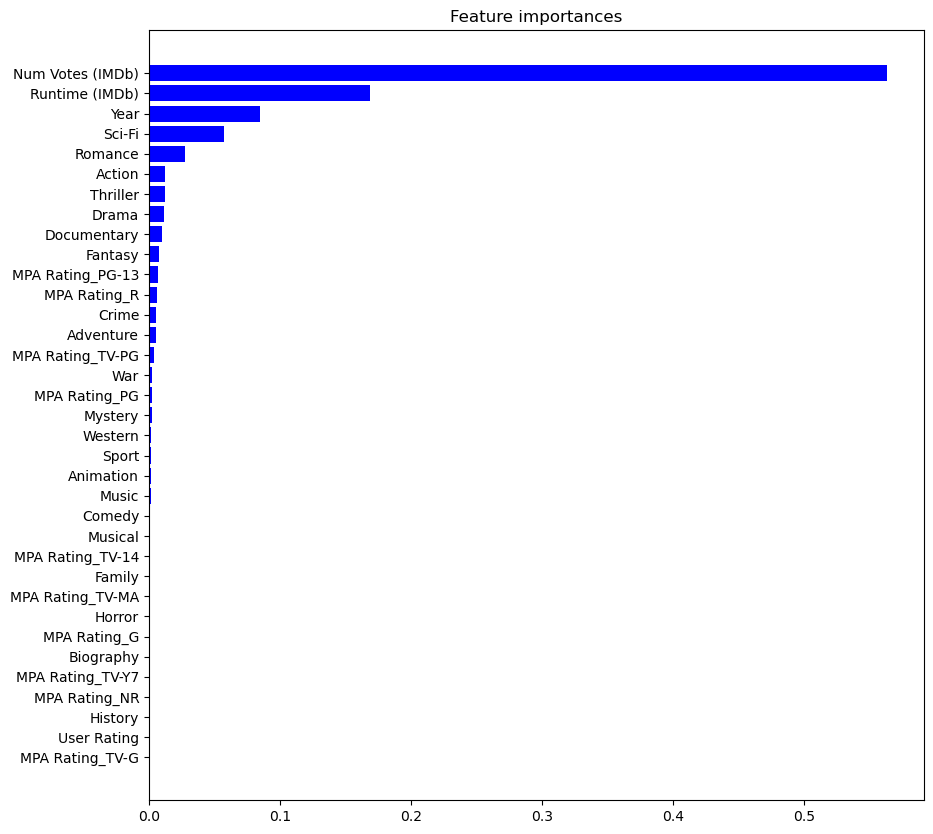

In [158]:
importances = rfr.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Create a bar plot of the feature importances
plt.figure(figsize=(10, 10))
plt.title("Feature importances")

# There are no parameter with negative importance in this dataset
colors = np.array(['red' if i < 0 else 'blue' for i in importances])

plt.barh(range(X.shape[1]), importances[indices][::-1], color=colors[indices])
plt.yticks(range(X.shape[1]), X.columns[indices][::-1])

plt.show()

Number of Votes is sort of dragging the solution in our prediciton model since we are accounting for millions of user rating and when there are many ratings for once specific movie, many rows are going to have the number of voting which might play a big role in the model.

## References
1. Documentation for sklearn.preprocessing.MultiLabelBinarizer, https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html 
2. Documentation for XGBoost, https://xgboost.readthedocs.io/en/stable/python/python_intro.html
3. Class Slides, previous labs and assignments 